In [1]:
#Step 1: Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#Step 2: Define File Path from Google Drive
csv_path ="file:///content/drive/MyDrive/Assessment2_707/integrated_final_df.csv"

In [15]:
#Step 3: Create Spark Session
#Spark will read data from Drive.
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GoogleDrive_to_HDFS") \
    .getOrCreate()

print("Spark session started")

Spark session started


In [8]:
# Download Hadoop
!wget -q -O hadoop-3.3.6.tar.gz https://downloads.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz

In [9]:
# Extract Hadoop to /usr/local/hadoop
!mkdir -p /usr/local/hadoop
!tar -xzf hadoop-3.3.6.tar.gz -C /usr/local/hadoop --strip-components 1

# Verify extraction
!ls /usr/local/hadoop

bin  include  libexec	      licenses-binary  NOTICE-binary  README.txt  share
etc  lib      LICENSE-binary  LICENSE.txt      NOTICE.txt     sbin


In [10]:
# Install OpenJDK 11 if not already installed
# Explicitly set PATH for apt-get to ensure it's found
!PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:$PATH apt-get update -qq > /dev/null
!PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:$PATH apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# Directly set JAVA_HOME path, bypassing problematic dynamic lookup
java_home = "/usr/lib/jvm/java-11-openjdk-amd64"

import os
# Set environment variables for the current Colab session
os.environ["JAVA_HOME"] = java_home
os.environ["HADOOP_HOME"] = "/usr/local/hadoop"
os.environ["PATH"] = os.environ["PATH"] + ":" + os.environ["HADOOP_HOME"] + "/bin" + ":" + os.environ["HADOOP_HOME"] + "/sbin"

# Also set for subsequent shell commands via magic command
%env JAVA_HOME=$java_home
%env HADOOP_HOME=/usr/local/hadoop
%env PATH=$PATH:$HADOOP_HOME/bin:$HADOOP_HOME/sbin

# Update Hadoop configuration files
# core-site.xml
core_site_content = """<configuration>
    <property>
        <name>fs.defaultFS</name>
        <value>hdfs://localhost:9000</value>
    </property>
</configuration>"""
with open('/usr/local/hadoop/etc/hadoop/core-site.xml', 'w') as f:
    f.write(core_site_content)

# hdfs-site.xml
hdfs_site_content = """<configuration>
    <property>
        <name>dfs.replication</name>
        <value>1</value>
    </property>
    <property>
        <name>dfs.namenode.name.dir</name>
        <value>file:///usr/local/hadoop/hdfs/namenode</value>
    </property>
    <property>
        <name>dfs.datanode.data.dir</name>
        <value>file:///usr/local/hadoop/hdfs/datanode</value>
    </property>
</configuration>"""
with open('/usr/local/hadoop/etc/hadoop/hdfs-site.xml', 'w') as f:
    f.write(hdfs_site_content)

# mapred-site.xml
mapred_site_content = """<configuration>
    <property>
        <name>mapreduce.framework.name</name>
        <value>yarn</value>
    </property>
</configuration>"""
with open('/usr/local/hadoop/etc/hadoop/mapred-site.xml', 'w') as f:
    f.write(mapred_site_content)

# yarn-site.xml
yarn_site_content = """<configuration>
    <property>
        <name>yarn.nodemanager.aux-services</name>
        <value>mapreduce_shuffle</value>
    </property>
    <property>
        <name>yarn.nodemanager.aux-services.mapreduce_shuffle.class</name>
        <value>org.apache.hadoop.mapred.ShuffleHandler</value>
    </property>
</configuration>"""
with open('/usr/local/hadoop/etc/hadoop/yarn-site.xml', 'w') as f:
    f.write(yarn_site_content)

# Update hadoop-env.sh to include JAVA_HOME (overwrite to ensure correctness)
with open('/usr/local/hadoop/etc/hadoop/hadoop-env.sh', 'w') as f:
    f.write(f'export JAVA_HOME="{java_home}"\n')
    f.write('export HADOOP_HOME="/usr/local/hadoop"\n')
    f.write('export PATH=$PATH:$HADOOP_HOME/bin:$HADOOP_HOME/sbin\n')

print(f"Hadoop environment variables set and configuration files updated. JAVA_HOME set to: {java_home}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
env: JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64
env: HADOOP_HOME=/usr/local/hadoop
env: PATH=$PATH:$HADOOP_HOME/bin:$HADOOP_HOME/sbin
Hadoop environment variables set and configuration files updated. JAVA_HOME set to: /usr/lib/jvm/java-11-openjdk-amd64


In [11]:
# Format the HDFS NameNode
!export JAVA_HOME="/usr/lib/jvm/java-11-openjdk-amd64" && export PATH="/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/hadoop/bin:/usr/local/hadoop/sbin" && hdfs namenode -format -force

2026-01-26 21:36:46,561 INFO namenode.NameNode: STARTUP_MSG: 
/************************************************************
STARTUP_MSG: Starting NameNode
STARTUP_MSG:   host = e345cc97df69/172.28.0.12
STARTUP_MSG:   args = [-format, -force]
STARTUP_MSG:   version = 3.3.6
STARTUP_MSG:   classpath = /usr/local/hadoop/etc/hadoop:/usr/local/hadoop/share/hadoop/common/lib/kerb-server-1.0.1.jar:/usr/local/hadoop/share/hadoop/common/lib/metrics-core-3.2.4.jar:/usr/local/hadoop/share/hadoop/common/lib/jetty-io-9.4.51.v20230217.jar:/usr/local/hadoop/share/hadoop/common/lib/kerb-crypto-1.0.1.jar:/usr/local/hadoop/share/hadoop/common/lib/netty-codec-redis-4.1.89.Final.jar:/usr/local/hadoop/share/hadoop/common/lib/netty-handler-ssl-ocsp-4.1.89.Final.jar:/usr/local/hadoop/share/hadoop/common/lib/jackson-core-asl-1.9.13.jar:/usr/local/hadoop/share/hadoop/common/lib/jsr311-api-1.1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/curator-framework-5.2.0.jar:/usr/local/hadoop/share/hadoop/common/lib/ne

In [12]:
# Start HDFS daemons individually without SSH
!export JAVA_HOME="/usr/lib/jvm/java-11-openjdk-amd64" && \
 export PATH="/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/hadoop/bin:/usr/local/hadoop/sbin" && \
 export HDFS_NAMENODE_USER=root && \
 export HDFS_DATANODE_USER=root && \
 export HDFS_SECONDARYNAMENODE_USER=root && \
 export YARN_RESOURCEMANAGER_USER=root && \
 export YARN_NODEMANAGER_USER=root && \
 hdfs --daemon start namenode && \
 hdfs --daemon start datanode && \
 hdfs --daemon start secondarynamenode

# Verify HDFS daemons are running
!export JAVA_HOME="/usr/lib/jvm/java-11-openjdk-amd64" && \
 export PATH="/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/hadoop/bin:/usr/local/hadoop/sbin:$JAVA_HOME/bin" && \
 jps

2949 SecondaryNameNode
665 SparkSubmit
2989 Jps
2894 DataNode
2831 NameNode


In [18]:
#Step 4: Load CSV from Google Drive into Spark
#Reads the cleaned integrated dataset from Google Drive.Converts it into a distributed Spark DataFrame.


final_integrated_df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(csv_path)

final_integrated_df.show(5)

+--------------------+---+------+---------+---------+----+--------------+-----------+-----------------+--------------+-------------------+-----------------------+------------------+-----------------+---------------+------------------+------------------+--------------+--------------+----------------+--------------+-------------------+----------------+
|          patient_id|age|gender|weight_kg|height_cm| bmi|smoking_status|alcohol_use|physical_activity|social_support|mental_health_issue|num_previous_admissions|chronic_conditions|medications_count|last_hemoglobin|      last_glucose|   last_creatinine|admission_type|length_of_stay|procedures_count|insurance_type|followup_compliance|readmission_risk|
+--------------------+---+------+---------+---------+----+--------------+-----------+-----------------+--------------+-------------------+-----------------------+------------------+-----------------+---------------+------------------+------------------+--------------+--------------+-----------

In [19]:
#Step 5: Write DataFrame into HDFS
hdfs_path = "hdfs://localhost:9000/user/data/processed/final_integrated"

final_integrated_df.write \
    .mode("overwrite") \
    .parquet(hdfs_path)

print("Data successfully ingested into HDFS")

Data successfully ingested into HDFS


In [20]:
#Step 6: Read data back from HDFS into a new DataFrame
read_df = spark.read.parquet(hdfs_path)

# Display the first 5 rows of the new DataFrame
print("Data read back from HDFS:")
read_df.show(5)

Data read back from HDFS:
+--------------------+---+------+---------+---------+----+--------------+-----------+-----------------+--------------+-------------------+-----------------------+------------------+-----------------+---------------+------------------+------------------+--------------+--------------+----------------+--------------+-------------------+----------------+
|          patient_id|age|gender|weight_kg|height_cm| bmi|smoking_status|alcohol_use|physical_activity|social_support|mental_health_issue|num_previous_admissions|chronic_conditions|medications_count|last_hemoglobin|      last_glucose|   last_creatinine|admission_type|length_of_stay|procedures_count|insurance_type|followup_compliance|readmission_risk|
+--------------------+---+------+---------+---------+----+--------------+-----------+-----------------+--------------+-------------------+-----------------------+------------------+-----------------+---------------+------------------+------------------+--------------+

select the 'age' and 'readmission_risk' columns from the read_df Spark DataFrame and then convert the resulting Spark DataFrame to a Pandas DataFrame, storing it in age_readmission_data.



## Create Box Plot of Age vs. Readmission Risk




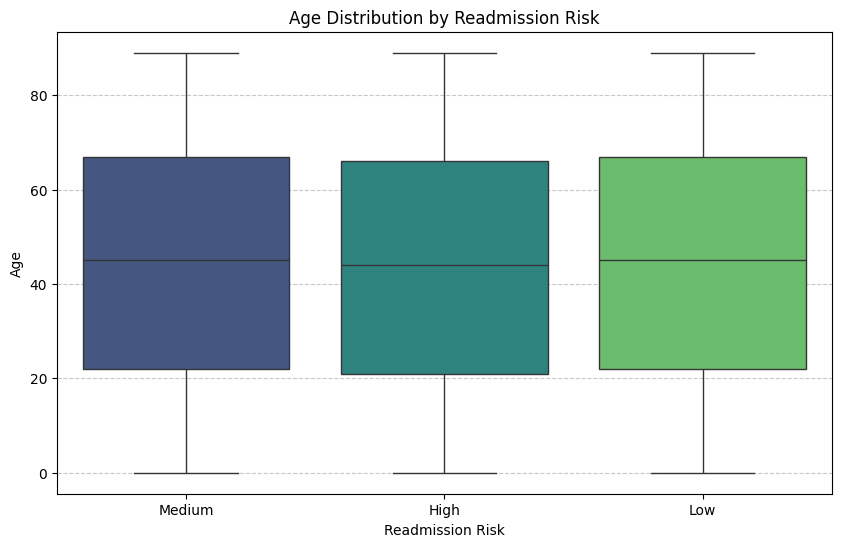

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
age_readmission_data = read_df.select("age", "readmission_risk").toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='readmission_risk', y='age', data=age_readmission_data, palette='viridis', hue='readmission_risk', legend=False)
plt.title('Age Distribution by Readmission Risk')
plt.xlabel('Readmission Risk')
plt.ylabel('Age')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()